# Setup

In [10]:
print("[*] Installing dependencies...")
!pip -q install scikit-learn xgboost tqdm matplotlib pandas > /dev/null 2>&1
print("[*] Installation: DONE")

print("[*] Downloading your email datasets from GitHub...")
!wget -O Merged_All_Emails.csv https://github.com/sanderhs1/masterd/raw/main/Merged_All_Emails.csv -q
!wget -O synthetic_emails_50.csv https://github.com/sanderhs1/masterd/raw/main/synthetic_emails_50.csv -q
print("[*] Download: DONE")

print("[*] Loading packages...")
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
print("[*] Load: DONE")

[*] Installing dependencies...
[*] Installation: DONE
[*] Downloading your email datasets from GitHub...
[*] Download: DONE
[*] Loading packages...
[*] Load: DONE


# Preprocess

In [24]:
# Configure paths for this Colab session
TRAIN_CSV    = "/content/Merged_All_Emails.csv"
TEST_CSV     = "/content/synthetic_emails_50.csv"
TARGET_COL   = "label"
FEATURE_COLS = ["subject", "body", "urls"]  # Removed URLS for now

# Load
train_df = pd.read_csv(TRAIN_CSV)
test_df  = pd.read_csv(TEST_CSV)

print("Train shape:", train_df.shape)
print("Test  shape:", test_df.shape)

# Check required columns exist
def require_cols(df, name):
    missing = [c for c in FEATURE_COLS + [TARGET_COL] if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns in {name}: {missing}")

require_cols(train_df, "TRAIN")
require_cols(test_df, "TEST")

# Normalize dtypes / basic cleaning
for df in (train_df, test_df):
    df["subject"] = df["subject"].astype(str).fillna("").str.strip()
    df["body"]    = df["body"].astype(str).fillna("").str.strip()
    df["text"]    = (df["subject"] + " " + df["body"]).str.strip()
    df["urls"]    = pd.to_numeric(df["urls"], errors="coerce").fillna(0.0)


# Peek at label distribution
print("\nLabel distribution (TRAIN):")
print(train_df[TARGET_COL].value_counts())

print("\nLabel distribution (TEST):")
print(test_df[TARGET_COL].value_counts())

Train shape: (2310, 8)
Test  shape: (50, 8)

Label distribution (TRAIN):
label
2    770
0    770
1    770
Name: count, dtype: int64

Label distribution (TEST):
label
0    20
1    15
2    15
Name: count, dtype: int64


# Sanity check 1

In [ ]:
# SANITY CHECK 1
train_df["text"] = (
    train_df["subject"] + " " + train_df["body"] + " __LBL__" + train_df["label"].astype(str)
)
print("⚠️  Running APPEND-LABEL sanity test: expect F1 ≈ 1.0 if pipeline works.")

# Baselines

[*] Precomputing feature matrix... done. (N=2310)

[*] Evaluating sample size: 200
=== Results for sample size 200 Validation ===
KNN             | Acc: 0.850 | Prec: 0.873 | Recall: 0.850 | F1: 0.853 | Time: 0.00s
Random Forest   | Acc: 0.875 | Prec: 0.910 | Recall: 0.875 | F1: 0.876 | Time: 2.41s
Bagging (DT)    | Acc: 0.800 | Prec: 0.829 | Recall: 0.800 | F1: 0.805 | Time: 0.53s
SVM (Linear)    | Acc: 0.825 | Prec: 0.853 | Recall: 0.825 | F1: 0.825 | Time: 0.01s
SVM (RBF)       | Acc: 0.675 | Prec: 0.729 | Recall: 0.675 | F1: 0.678 | Time: 0.04s
Decision Tree   | Acc: 0.700 | Prec: 0.711 | Recall: 0.700 | F1: 0.699 | Time: 0.08s
XGBoost         | Acc: 0.925 | Prec: 0.925 | Recall: 0.925 | F1: 0.925 | Time: 17.24s

[*] Evaluating sample size: 500
=== Results for sample size 500 Validation ===
KNN             | Acc: 0.900 | Prec: 0.902 | Recall: 0.900 | F1: 0.899 | Time: 0.00s
Random Forest   | Acc: 0.930 | Prec: 0.935 | Recall: 0.930 | F1: 0.930 | Time: 5.69s
Bagging (DT)    | Acc: 0

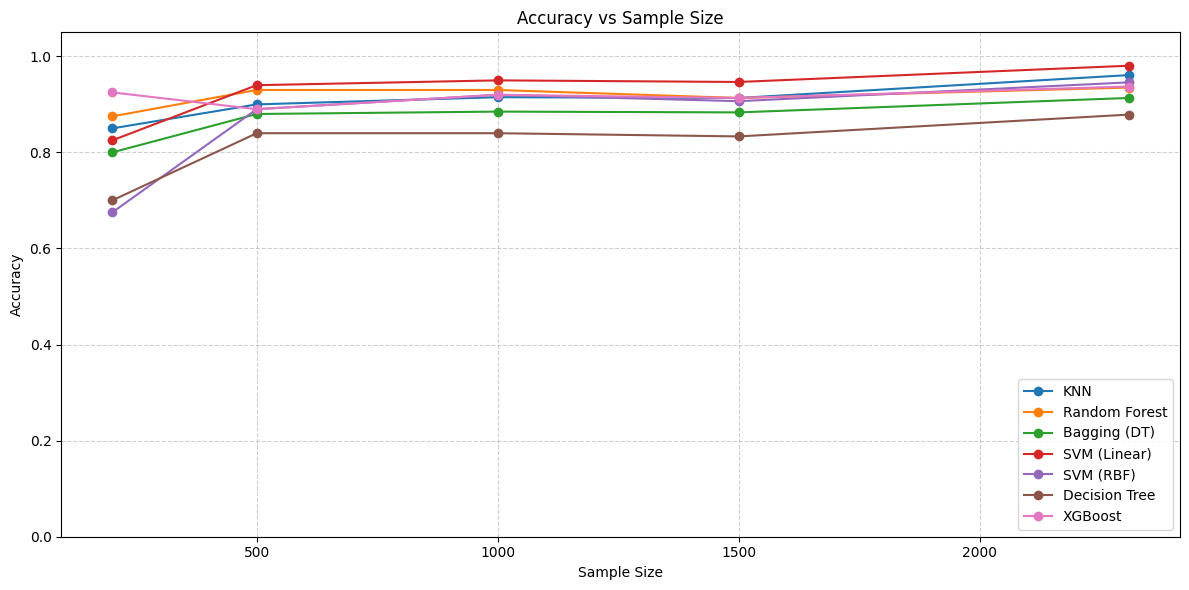

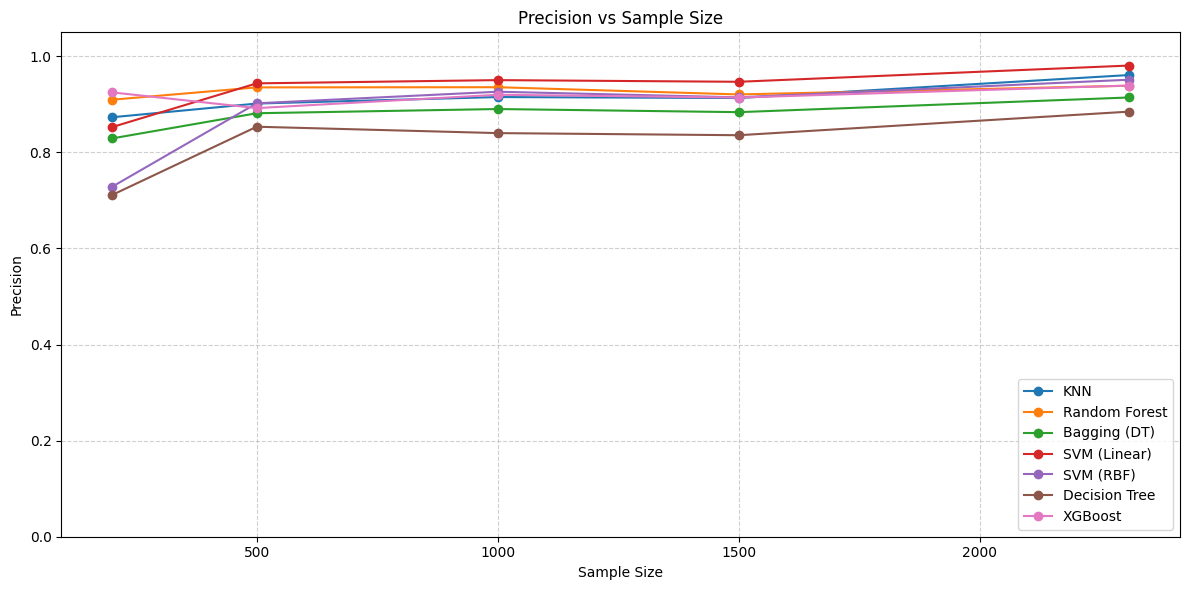

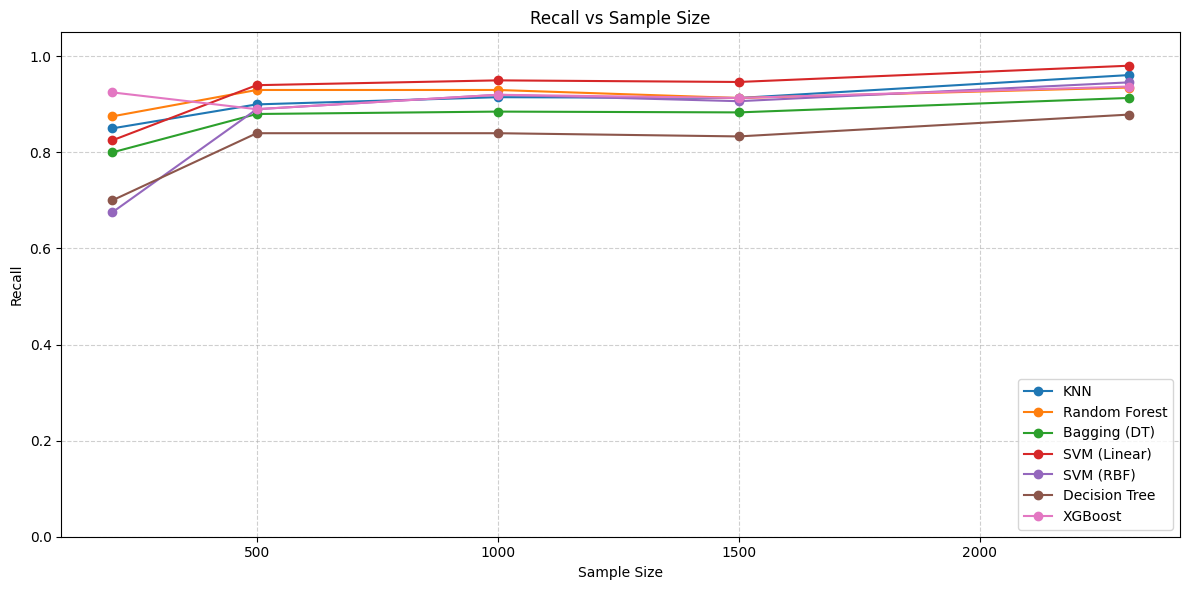

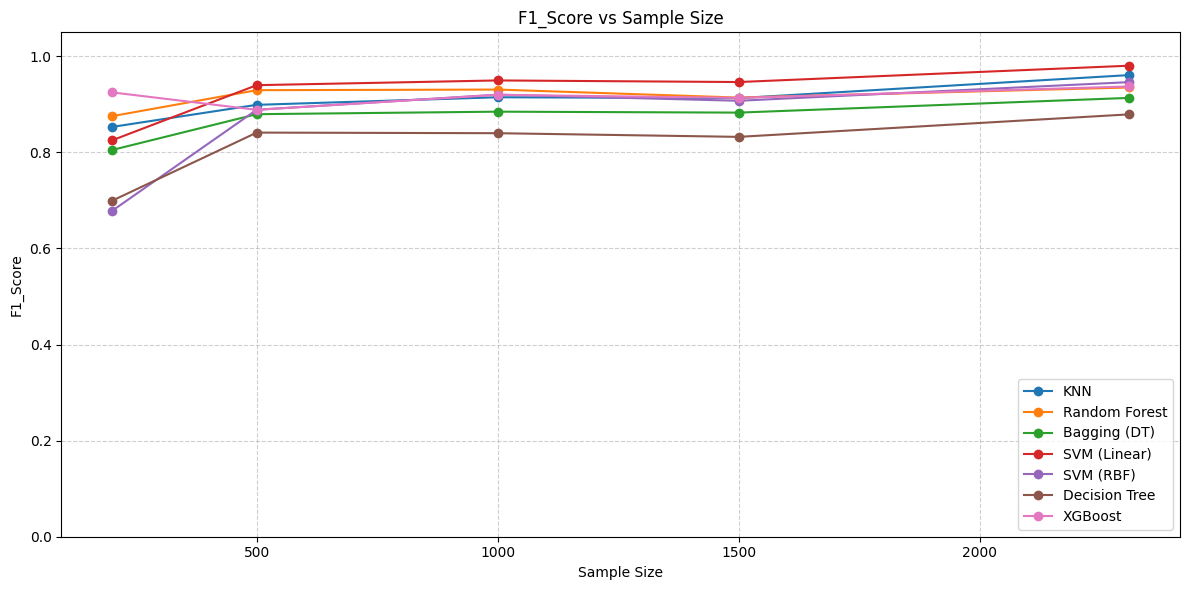

In [26]:
import time, warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.sparse import hstack, csr_matrix
from sklearn.utils import shuffle

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np

# Encode labels on TRAIN (and keep encoder for names)
y_full = train_df[TARGET_COL]
if y_full.dtype == "object" or str(y_full.dtype).startswith("category"):
    encoder = LabelEncoder().fit(y_full)
    y_full = encoder.transform(y_full)
else:
    encoder = None

# TF-IDF on text; add URLs as numeric feature
tfidf = TfidfVectorizer(
    max_features=40000,
    ngram_range=(1, 2),
    lowercase=True,
    #token_pattern=r"(?u)\b\w+\b"   # <-- allows 1-char tokens and digits
)
X_text = tfidf.fit_transform(train_df["text"])
X_urls = csr_matrix(train_df["urls"].to_numpy().reshape(-1, 1))
X_full = hstack([X_text, X_urls]).tocsr()

def get_models():
    return {
        'KNN': KNeighborsClassifier(),
        'Random Forest': RandomForestClassifier(n_estimators=400, random_state=42),
        'Bagging (DT)': BaggingClassifier(DecisionTreeClassifier(), random_state=42),
        'SVM (Linear)': LinearSVC(max_iter=2000, random_state=42),
        'SVM (RBF)': SVC(kernel='rbf', random_state=42),
        'Decision Tree': DecisionTreeClassifier(max_depth=12, random_state=42),
        'XGBoost': XGBClassifier(
            n_estimators=400, max_depth=8, tree_method="hist",
            subsample=0.9, colsample_bytree=0.9,
            eval_metric="mlogloss", random_state=42
        )
    }

def evaluate_on_sample(X_full, y_full, sample_size):
    N = X_full.shape[0]  # <-- fix
    rng = np.random.RandomState(42)
    sample_size = min(sample_size, N)
    idx = rng.choice(N, size=sample_size, replace=False)
    X, y = X_full[idx], y_full[idx]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    models = get_models()
    metrics = {}
    for name, model in models.items():
        try:
            start = time.time()
            model.fit(X_train, y_train)
            train_time = time.time() - start
            y_pred = model.predict(X_test)
            # --- SANITY CHECK 2: Randomize validation labels ---
            #y_test_random = shuffle(y_test, random_state=42)
            #acc_rand  = accuracy_score(y_test_random, y_pred)
            #f1_rand   = f1_score(y_test_random, y_pred, average="weighted")
            # -----------------------------------------------------
            metrics[name] = {
                "accuracy":  accuracy_score(y_test, y_pred),
                "precision": precision_score(y_test, y_pred, average="weighted", zero_division=0),
                "recall":    recall_score(y_test, y_pred, average="weighted"),
                "f1_score":  f1_score(y_test, y_pred, average="weighted"),
                #"rand_acc":  acc_rand,
                #"rand_f1":   f1_rand,
                "train_time_sec": train_time
            }
        except Exception as e:
            print(f"❌ {name} failed on sample size {sample_size}: {e}")
    return metrics

def plot_sample_size_results(all_results, metric):
    sample_sizes = sorted(all_results.keys())
    models = list(next(iter(all_results.values())).keys())
    plt.figure(figsize=(12,6))
    for m in models:
        vals = [all_results[s][m][metric] for s in sample_sizes]
        plt.plot(sample_sizes, vals, marker='o', label=m)
    plt.title(f"{metric.title()} vs Sample Size")
    plt.xlabel("Sample Size"); plt.ylabel(metric.title()); plt.ylim(0, 1.05)
    plt.grid(True, linestyle='--', alpha=0.6); plt.legend(loc='lower right'); plt.tight_layout()
    plt.show()

def run_full_evaluation():
    N = X_full.shape[0]
    sample_sizes = [200, 500, 1000, 1500, 2310]
    all_results = {}
    print(f"[*] Precomputing feature matrix... done. (N={N})")

    for size in sample_sizes:
        print(f"\n[*] Evaluating sample size: {size}")
        metrics = evaluate_on_sample(X_full, y_full, size)
        all_results[size] = metrics

        print(f"=== Results for sample size {size} Validation ===")
        for model_name, scores in metrics.items():
            acc = scores["accuracy"]
            prec = scores["precision"]
            rec = scores["recall"]
            f1 = scores["f1_score"]
            time_sec = scores["train_time_sec"]
            print(f"{model_name:15s} | Acc: {acc:.3f} | Prec: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.3f} | Time: {time_sec:.2f}s")
            #print(f"{model_name:15s} | Acc: {acc:.3f} | F1: {f1:.3f} | Rand_Acc: {scores['rand_acc']:.3f} | Rand_F1: {scores['rand_f1']:.3f} | Time: {time_sec:.2f}s")  # SANITY 2


    for metric in ['accuracy', 'precision', 'recall', 'f1_score']:
        plot_sample_size_results(all_results, metric)


run_full_evaluation()


# Test dataset

In [ ]:
# === Evaluate ALL models on the external TEST set (same models/metrics/format) ===
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.sparse import hstack, csr_matrix
import time

print("\n[*] Building TEST features with the same tfidf + urls pipeline...")
Xte_text = tfidf.transform(test_df["text"])
Xte_urls = csr_matrix(test_df["urls"].to_numpy().reshape(-1, 1))
Xte = hstack([Xte_text, Xte_urls]).tocsr()

# Align TEST labels with the same encoder used on TRAIN
y_test_raw = test_df[TARGET_COL]
if encoder is not None:
    mask_seen = y_test_raw.isin(encoder.classes_)
    dropped = (~mask_seen).sum()
    if dropped > 0:
        print(f"⚠️ Dropping {dropped} TEST rows with unseen labels: {sorted(set(y_test_raw[~mask_seen]))}")
    y_test = encoder.transform(y_test_raw[mask_seen])
    Xte = Xte[mask_seen]
else:
    y_test = y_test_raw.to_numpy()

print("\n=== External TEST Results (all models) ===")
models = get_models()
for name, model in models.items():
    try:
        start = time.time()
        model.fit(X_full, y_full)  # train on ALL training data
        train_time = time.time() - start
        y_pred = model.predict(Xte)

        acc  = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, average="weighted", zero_division=0)
        rec  = recall_score(y_test, y_pred, average="weighted")
        f1   = f1_score(y_test, y_pred, average="weighted")

        print(f"{name:15s} | Acc: {acc:.3f} | Prec: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.3f} | Time: {train_time:.2f}s")
    except Exception as e:
        print(f"❌ {name} failed on external test: {e}")



[*] Building TEST features with the same tfidf + urls pipeline...

=== External TEST Results (all models) ===
KNN             | Acc: 0.640 | Prec: 0.725 | Recall: 0.640 | F1: 0.615 | Time: 0.01s
Random Forest   | Acc: 0.340 | Prec: 0.494 | Recall: 0.340 | F1: 0.216 | Time: 19.53s
Bagging (DT)    | Acc: 0.940 | Prec: 0.950 | Recall: 0.940 | F1: 0.940 | Time: 11.39s
SVM (Linear)    | Acc: 0.560 | Prec: 0.529 | Recall: 0.560 | F1: 0.495 | Time: 0.34s
SVM (RBF)       | Acc: 0.700 | Prec: 0.550 | Recall: 0.700 | F1: 0.600 | Time: 5.60s
Decision Tree   | Acc: 0.660 | Prec: 0.841 | Recall: 0.660 | F1: 0.643 | Time: 0.79s
